In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from precip.trainer import Trainer, TrainerArgs
from precip.data.dataset import SwedishPrecipitationDataset, InfiniteSampler
from precip.models.nowcastnet import NowcastNet

In [2]:
config = TrainerArgs('nowcastnet_test', wandb_track=False, number_of_steps=1_000, training_size_per_step=100, iterative_multistep=False, lr=3e-4, load_from_checkpoint=True, checkpoint_path='/home/tom/dev/precip/checkpoints/usual-tree-149QCKXT/step_num_90.pth',
                     lookback_start_5_mins_multiple= 12 * 12,
                    lookback_intervals_5_mins_multiple= 12,
                    forecast_horizon_start_5_mins_multiple=1,
                    forecast_horizon_end_5_mins_multiple=12 * 6,
                    forecast_intervals_5_mins_multiple= 12)

In [3]:
training_dataset = SwedishPrecipitationDataset(
    split="train",
    forecast_multistep=config.forecast_multistep,
    lookback_start_5_mins_multiple=config.lookback_start_5_mins_multiple,
    lookback_intervals_5_mins_multiple=config.lookback_intervals_5_mins_multiple,
    forecast_horizon_start_5_mins_multiple=config.forecast_horizon_start_5_mins_multiple,
    forecast_horizon_end_5_mins_multiple=config.forecast_horizon_end_5_mins_multiple,
    forecast_intervals_5_mins_multiple=config.forecast_intervals_5_mins_multiple,
    forecast_gap_5_mins_multiple=config.forecast_gap_5_mins_multiple,
)

validation_dataset = SwedishPrecipitationDataset(
    split="val",
    forecast_multistep=config.forecast_multistep,
    lookback_start_5_mins_multiple=config.lookback_start_5_mins_multiple,
    lookback_intervals_5_mins_multiple=config.lookback_intervals_5_mins_multiple,
    forecast_horizon_start_5_mins_multiple=config.forecast_horizon_start_5_mins_multiple,
    forecast_horizon_end_5_mins_multiple=config.forecast_horizon_end_5_mins_multiple,
    forecast_intervals_5_mins_multiple=config.forecast_intervals_5_mins_multiple,
    forecast_gap_5_mins_multiple=config.forecast_gap_5_mins_multiple,
)

model = NowcastNet(
    training_dataset.lookback_start_5_mins_multiple
    // training_dataset.lookback_intervals_5_mins_multiple,
    (
        training_dataset.forecast_horizon_end_5_mins_multiple
        + 1
        - training_dataset.forecast_horizon_start_5_mins_multiple
    )
    // training_dataset.forecast_intervals_5_mins_multiple,
).to(config.device)

In [4]:
trainer = Trainer(model, config, training_dataset, validation_dataset)

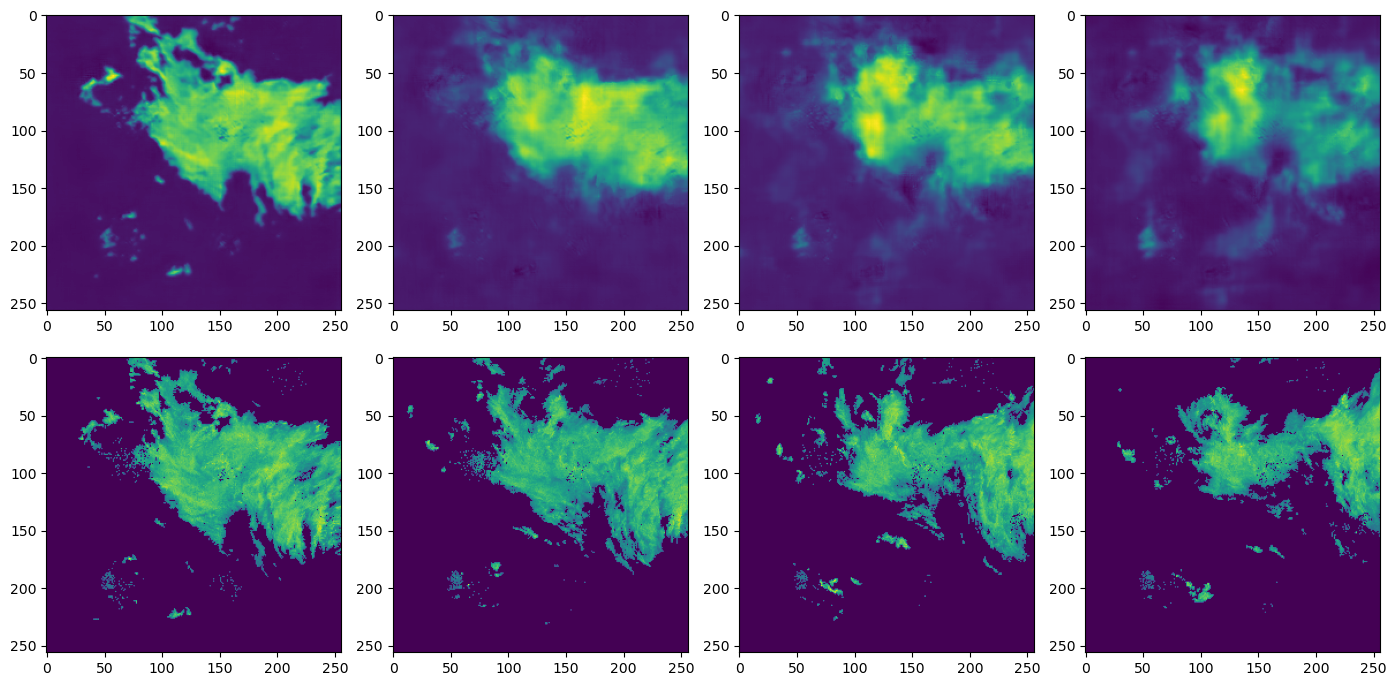

In [5]:
f, axes = plt.subplots(2, 4, figsize=(14, 7))

batch_X, batch_y = next(trainer.train_dataiter)
forecasts = trainer._prediction(batch_X=batch_X.to('cuda'))

for i in range(4):
    axes[0, i].imshow(forecasts[0, i, ...].detach().cpu().numpy())
    axes[1, i].imshow(batch_y[0, i, ...].detach().cpu().numpy())
    
f.tight_layout()

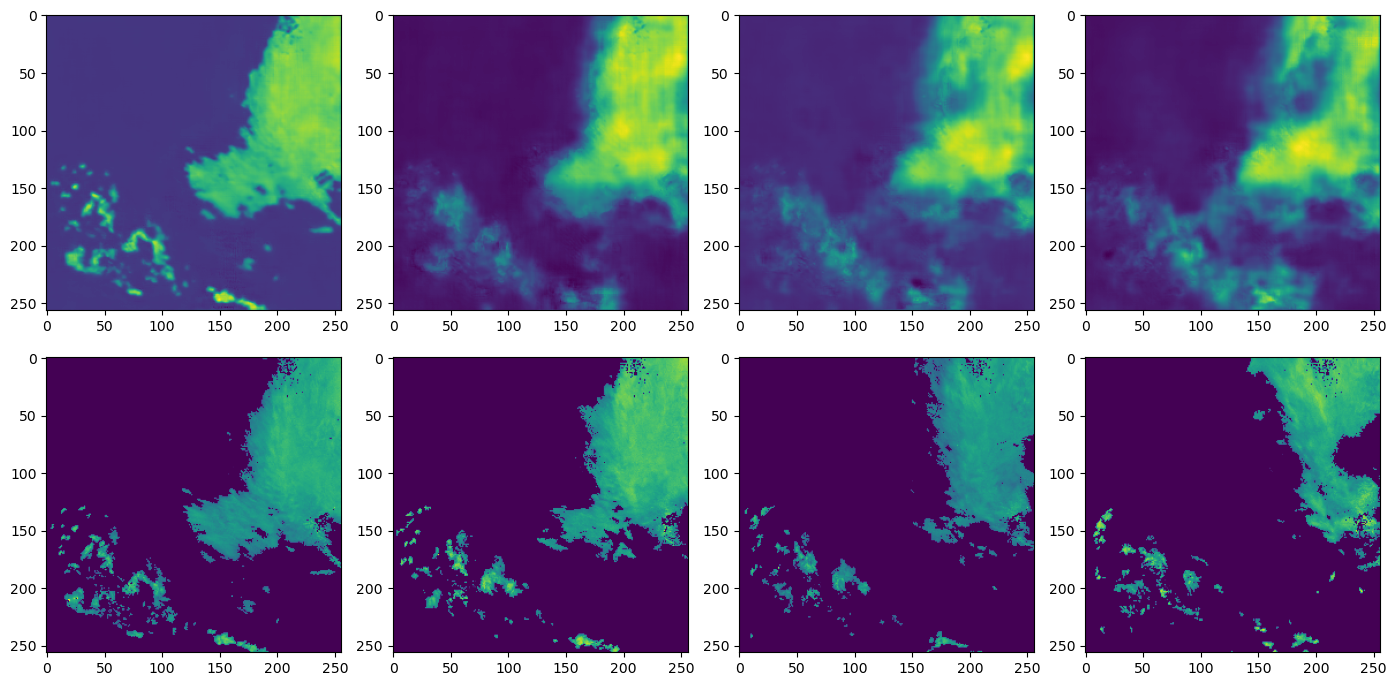

In [6]:
f, axes = plt.subplots(2, 4, figsize=(14, 7))

batch_X, batch_y = next(trainer.val_dataiter)
forecasts = trainer._prediction(batch_X=batch_X.to('cuda'))

for i in range(4):
    axes[0, i].imshow(forecasts[0, i, ...].detach().cpu().numpy())
    axes[1, i].imshow(batch_y[0, i, ...].detach().cpu().numpy())
    
f.tight_layout()

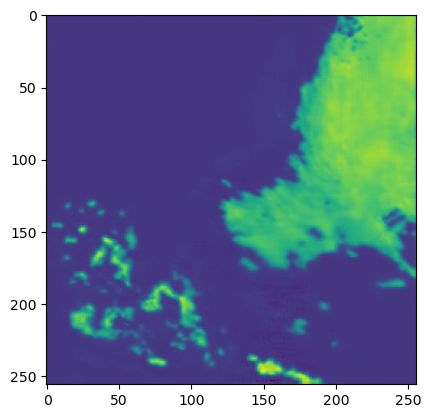

In [7]:
plt.imshow(trainer.output_transform(forecasts[0][0]).detach().cpu().numpy())

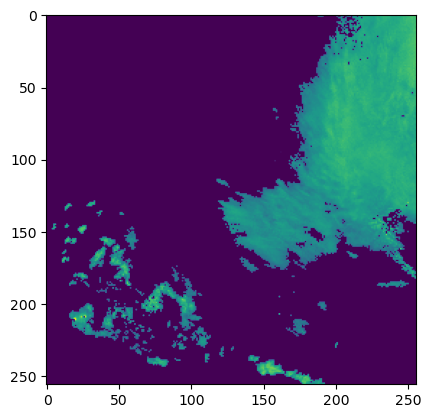

In [8]:
plt.imshow(trainer.output_transform(batch_y[0][0]).detach().cpu().numpy())

In [9]:
with torch.no_grad():
    l = trainer.loss(forecasts, batch_y.cuda())

In [12]:
trainer.loss(torch.rand_like(batch_y), batch_y)

tensor(0.2856)

In [13]:
l

tensor(2660.3872, device='cuda:0')

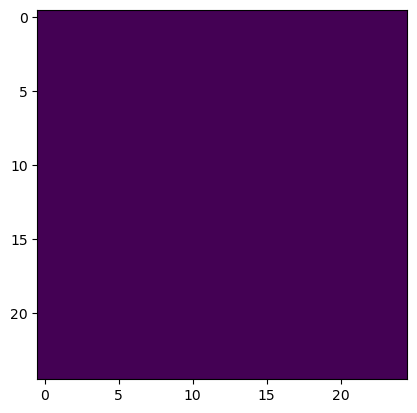

In [11]:
plt.imshow(batch_y[0, 0, 50:75, 50:75].numpy())

In [14]:
batch_X[0, 5].sum()

tensor(7736.6348)

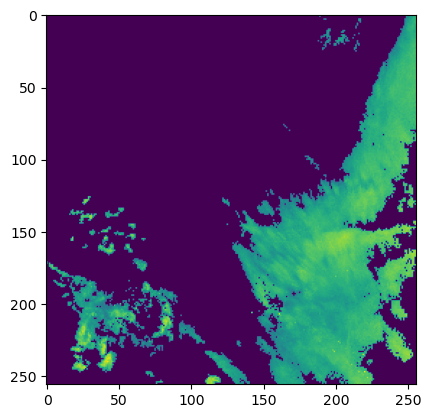

In [16]:
plt.imshow(batch_X[0][5].numpy())

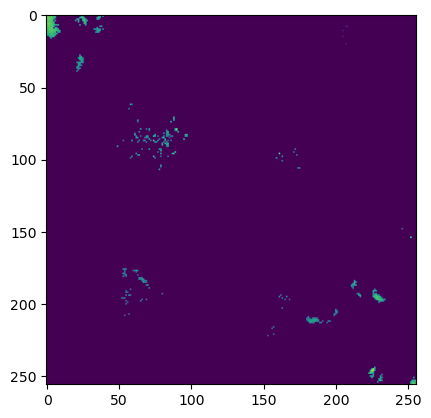

In [71]:
plt.imshow(batch_X[0][2].numpy())

In [63]:
batch_y[0, 0].sum()

tensor(1905217.)

In [ ]:
trainer.train_dataiter

In [32]:
torch.rand_like(batch_y)

tensor([[[[0.9002, 0.4027, 0.9074,  ..., 0.6472, 0.2902, 0.7077],
          [0.9442, 0.3351, 0.4881,  ..., 0.6072, 0.1458, 0.1641],
          [0.0956, 0.1834, 0.9089,  ..., 0.3953, 0.9183, 0.2543],
          ...,
          [0.0789, 0.3617, 0.9645,  ..., 0.0603, 0.8391, 0.7849],
          [0.0783, 0.2151, 0.9538,  ..., 0.9271, 0.2544, 0.5866],
          [0.4159, 0.7257, 0.5680,  ..., 0.0821, 0.6158, 0.2016]],

         [[0.3179, 0.4136, 0.0671,  ..., 0.9867, 0.4413, 0.8731],
          [0.8673, 0.8222, 0.3053,  ..., 0.1277, 0.6534, 0.1162],
          [0.4551, 0.9695, 0.8116,  ..., 0.7150, 0.2074, 0.8911],
          ...,
          [0.1345, 0.3181, 0.7764,  ..., 0.7834, 0.3424, 0.1731],
          [0.1369, 0.1144, 0.2675,  ..., 0.5412, 0.6438, 0.5519],
          [0.7916, 0.0304, 0.0363,  ..., 0.6546, 0.3290, 0.2576]],

         [[0.1834, 0.2496, 0.7259,  ..., 0.7117, 0.5713, 0.0129],
          [0.3951, 0.7791, 0.2385,  ..., 0.8242, 0.1432, 0.3177],
          [0.0613, 0.6871, 0.0537,  ..., 0

In [31]:
l

tensor(2174.6235, device='cuda:0')

In [25]:
40 *40

1600

In [19]:
trainer.output_transform(forecasts[0][0]).detach().cpu().numpy()

array([[ 1.3737094 ,  2.0732243 ,  1.7826687 , ...,  3.9171247 ,
         5.9999814 , 12.233631  ],
       [ 2.2827218 ,  2.0248597 ,  1.0911787 , ..., -0.4629277 ,
         1.5358052 ,  6.185118  ],
       [ 1.4476299 ,  1.8217504 ,  1.5657794 , ..., -0.10695963,
         1.603363  ,  5.461567  ],
       ...,
       [ 1.6770328 ,  2.7521296 ,  2.546785  , ...,  1.7767481 ,
         1.8942624 , -0.3733399 ],
       [ 2.0842435 ,  2.9323163 ,  3.0189536 , ...,  2.6160855 ,
         4.299052  ,  3.2904232 ],
       [-1.8503435 ,  0.57409054,  0.8155933 , ...,  2.9041061 ,
         3.5417151 ,  4.2418036 ]], dtype=float32)

In [15]:
batch_y[0][0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])